# TASK 2 : Clustering Analysis  #

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

In [2]:
#load scaled dataset from Task 1
scaled_df = pd.read_csv("clustering_data_scaled.csv")
print("Data shape:", scaled_df.shape)
scaled_df.head()

Data shape: (528, 64)


,averageCqiDl_mean,avgServedBlocksDl_mean,end2endDelay_mean,firstFrameElapsedTime_mean,frameSize_mean,framesDisplayed_mean,interArrivalTimeRtp_mean,playoutBufferLength_mean,positionX_mean,positionY_mean,...,interArrivalTimeRtp_max,playoutBufferLength_max,positionX_max,positionY_max,positionZ_max,rcvdSinrDl_max,rtpLoss_max,rtpPacketSize_max,servingCell_max,velocity_max
0,-0.127921,1.867005,-0.189738,-0.219424,-1.29612,-1.290577,-1.202016,-1.294374,0.070208,0.078886,...,-0.989481,-1.281501,0.429464,0.428418,0.0,-0.015121,-1.24036,-1.46385,0.523882,0.100655
1,-0.127921,0.735874,-0.189738,-0.219424,-1.29612,-1.290577,-1.202016,-1.294374,0.070208,0.078886,...,-0.989481,-1.281501,0.429464,0.428418,0.0,-0.015121,-1.24036,-1.46385,0.523882,0.100655
2,-0.127921,-0.133039,-0.189738,-0.219424,-1.29612,-1.290577,-1.202016,-1.294374,0.070208,0.078886,...,-0.989481,-1.281501,0.429464,0.428418,0.0,-0.015121,-1.24036,-1.46385,0.523882,0.100655
3,-0.127921,0.010673,-0.189738,-0.219424,-1.29612,-1.290577,-1.202016,-1.294374,0.070208,0.078886,...,-0.989481,-1.281501,0.429464,0.428418,0.0,-0.015121,-1.24036,-1.46385,0.523882,0.100655
4,-0.127921,-0.144321,-0.189738,-0.219424,-1.29612,-1.290577,-1.202016,-1.294374,0.070208,0.078886,...,-0.989481,-1.281501,0.429464,0.428418,0.0,-0.015121,-1.24036,-1.46385,0.523882,0.100655


## Feature analysis / Correlation 

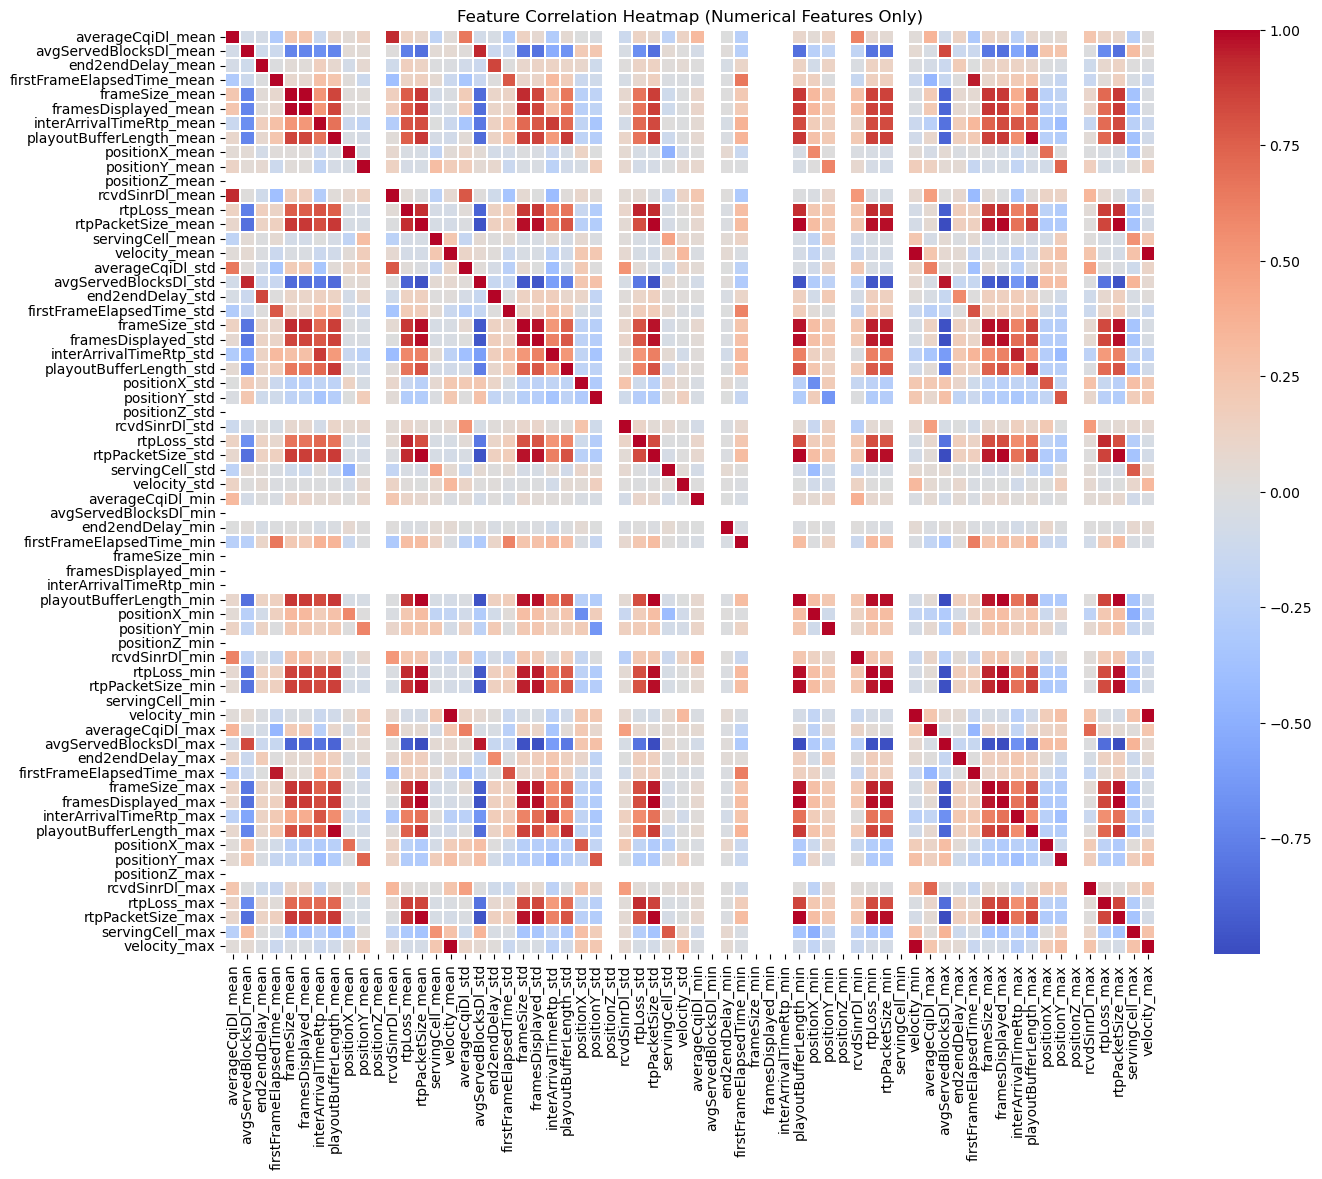

In [3]:
#exclude categorical or location features if any
numerical_features = scaled_df.select_dtypes(include=[np.number])

#correlation heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(numerical_features.corr(), cmap='coolwarm', linewidths=0.1, annot=False)
plt.title("Feature Correlation Heatmap (Numerical Features Only)")
plt.show()

The correlation heatmap shows strong relationships between related network performance features. In particular, metrics derived from similar measurements such as mean, min, max, and standard deviation versions of the same variable, tend to be highly correlated, which is expected. Some QoS related features, such as delay, packet size, and frame related metrics, also show moderate to strong associations with each other. This suggests that certain variables may carry overlapping information, but overall the feature set still shows multiple distinct aspects of network behaviour.

## K-Means Clustering ##

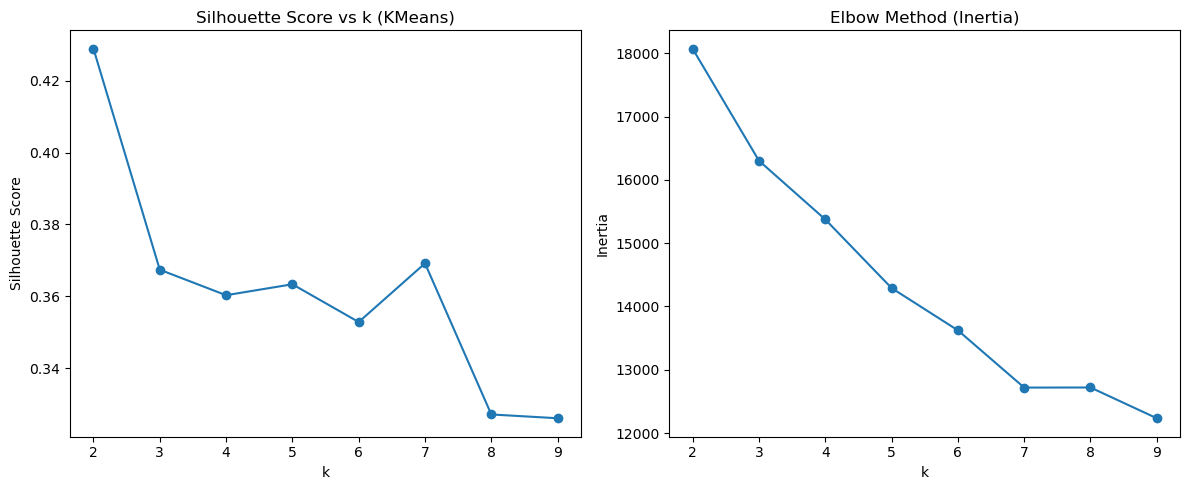

Selected k = 2 based on silhouette score


In [4]:
#try multiple k values
k_values = range(2, 10)
sils = []
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(numerical_features)
    sils.append(silhouette_score(numerical_features, labels))
    inertias.append(kmeans.inertia_)

#plot silhouette score and elbow method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, sils, marker='o')
plt.title("Silhouette Score vs k (KMeans)")
plt.xlabel("k")
plt.ylabel("Silhouette Score")

plt.subplot(1, 2, 2)
plt.plot(k_values, inertias, marker='o')
plt.title("Elbow Method (Inertia)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.tight_layout()
plt.show()

#select best k based on silhouette and elbow
best_k = k_values[np.argmax(sils)]
print(f"Selected k = {best_k} based on silhouette score")


Both silhouette score and the elbow method were used to determine the best K for values of k between 2 and 9. The silhouette score peaked at k = 2, suggesting that two clusters provide the clearest separation within the data. The elbow plot also shows a noticeable reduction in inertia at lower k values before the improvement begins to level off. Based on these results k = 2 was selected as the most suitable number of clusters for this dataset.

Top features differentiating clusters:

KMeans_Cluster                  0         1
playoutBufferLength_min -1.463850  0.683130
framesDisplayed_max     -1.463850  0.683130
rtpPacketSize_max       -1.463850  0.683130
avgServedBlocksDl_max    1.463848 -0.683129
rtpPacketSize_mean      -1.463778  0.683096
rtpPacketSize_std       -1.461920  0.682229
rtpLoss_min             -1.439736  0.671877
rtpPacketSize_min       -1.434488  0.669428
framesDisplayed_std     -1.434446  0.669408
frameSize_std           -1.428404  0.666588


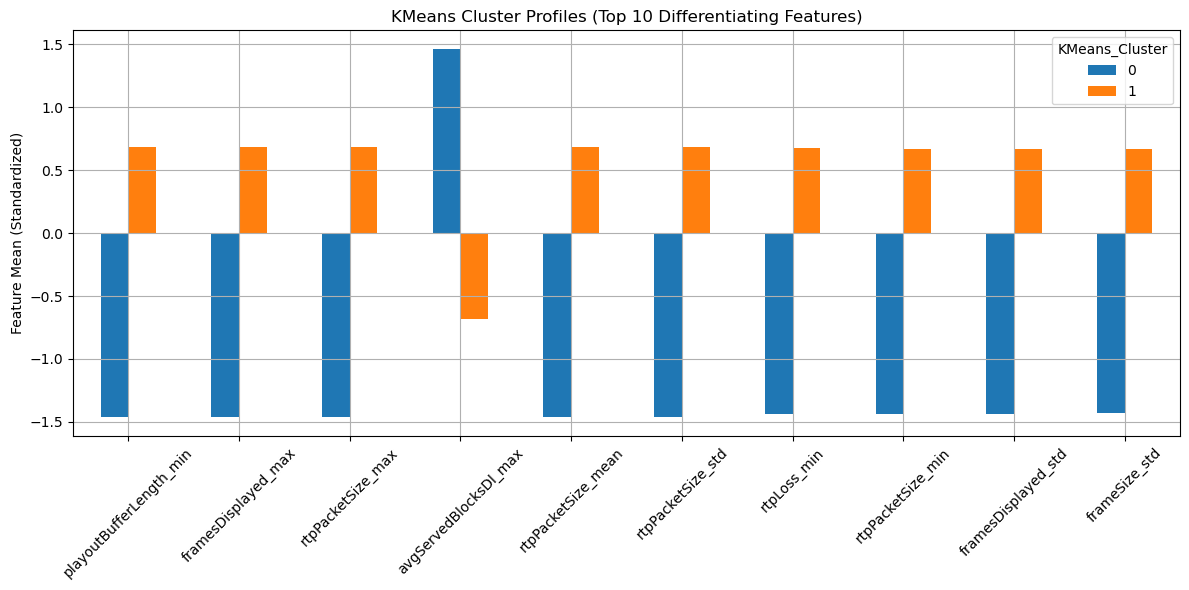

In [5]:
#fit KMeans with selected k
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans_labels = kmeans.fit_predict(numerical_features)

#add cluster labels
clustered_df = numerical_features.copy()
clustered_df['KMeans_Cluster'] = kmeans_labels

#feature comparison per cluster
cluster_summary = clustered_df.groupby('KMeans_Cluster').mean()
cluster_summary_T = cluster_summary.T

#top 10 features with highest variance across clusters
top_features = cluster_summary_T.std(axis=1).sort_values(ascending=False).head(10).index
print("Top features differentiating clusters:\n")
print(cluster_summary_T.loc[top_features])

#bar plot
cluster_summary_T.loc[top_features].plot(kind='bar', figsize=(12, 6))
plt.title("KMeans Cluster Profiles (Top 10 Differentiating Features)")
plt.ylabel("Feature Mean (Standardized)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


After fitting K-Means with k = 2 the mean standardized values of each feature were compared across clusters. The results show a clear separation between the two groups, with most of the top differentiating features taking opposite signs in each cluster. This indicates that the clusters represent specific and distrinct performance patterns rather than subtle variations within the same structure.

The strongest differences between clusters are mainly by packet related and playback features, with one cluster showing consistently higher standardised values for these features, while the other shows lower values but higher values for avgServedBlocksDl_max. Overall, this suggests that the clusters show two contrasting network performance profiles, specifically in terms of packet behaviour and media delivery characteristics.

## 2D PCA Visualisation ##

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


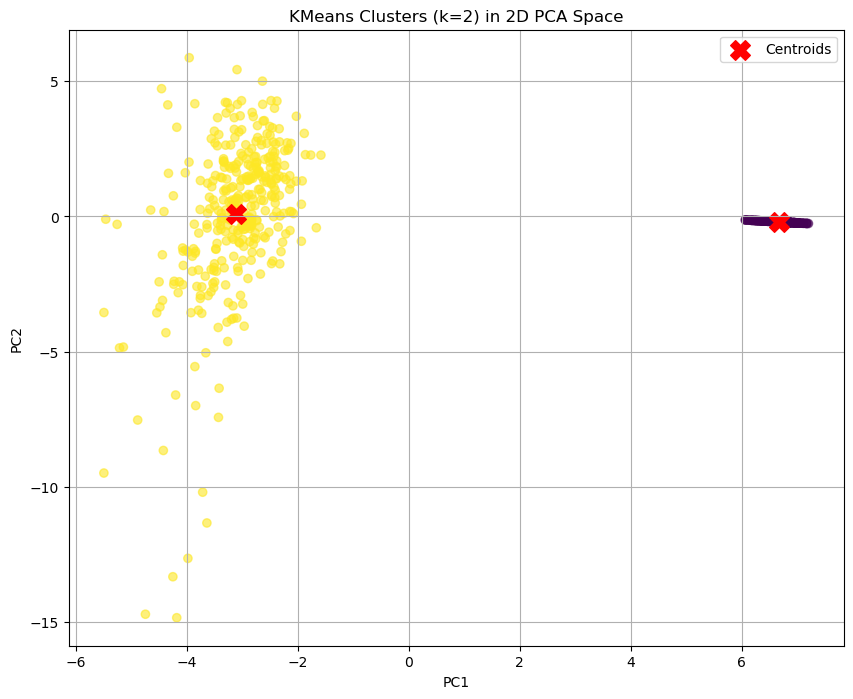

In [6]:
pca = PCA(n_components=2)
pca_2d = pca.fit_transform(numerical_features)

plt.figure(figsize=(10, 8))
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
plt.scatter(pca.transform(kmeans.cluster_centers_)[:,0], 
            pca.transform(kmeans.cluster_centers_)[:,1], 
            c='red', s=200, marker='X', label='Centroids')
plt.title(f"KMeans Clusters (k={best_k}) in 2D PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

The high dimensional feature space was reduced to two principal components using PCA was used to reduce the high dimensional data to two principal components, with each point reperesnting an observation Each point represents an observation. The visualisation shows a shows a clear separation between the two clusters along the first principal component, with minimal overlap between the groups. The centroids are positioned near the centre of each cluster, confirming that K-Means has identified two well-defined and distinct regions in the feature space. This visual evidence supports the earlier silhouette and elbow results, indicating that k=2 provides a meaningful clustering structure.

## Cluster Interpretation ##

KMeans_Cluster                  0         1
playoutBufferLength_min -1.463850  0.683130
framesDisplayed_max     -1.463850  0.683130
rtpPacketSize_max       -1.463850  0.683130
avgServedBlocksDl_max    1.463848 -0.683129
rtpPacketSize_mean      -1.463778  0.683096
rtpPacketSize_std       -1.461920  0.682229
rtpLoss_min             -1.439736  0.671877
rtpPacketSize_min       -1.434488  0.669428
framesDisplayed_std     -1.434446  0.669408
frameSize_std           -1.428404  0.666588


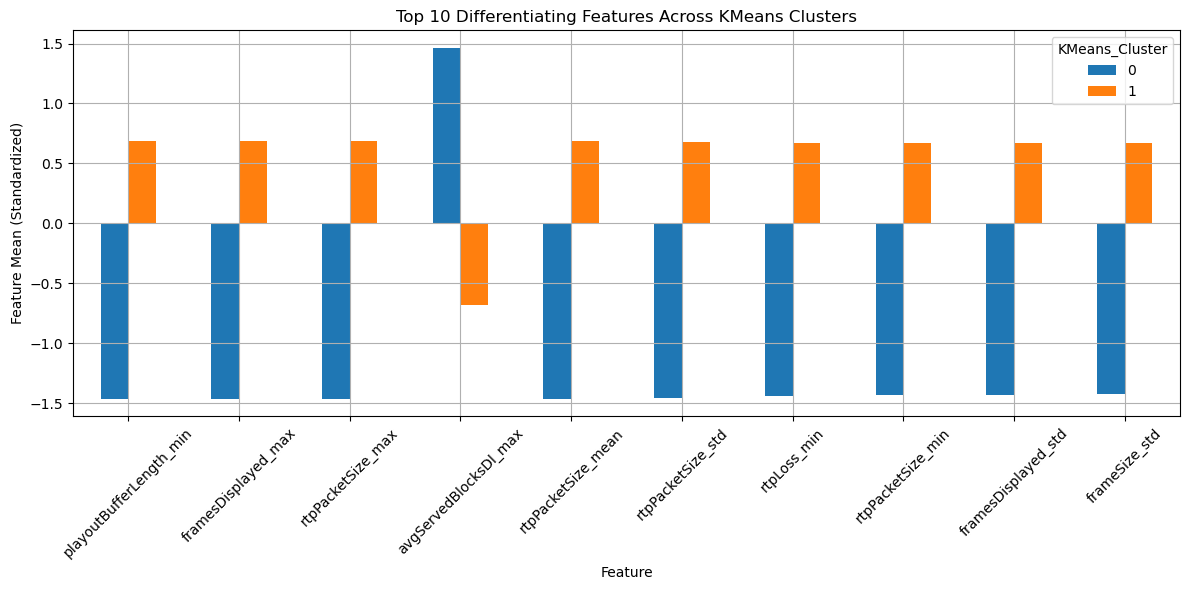

In [7]:
cluster_summary = clustered_df.groupby('KMeans_Cluster').mean().T
top_features = cluster_summary.std(axis=1).sort_values(ascending=False).head(10).index

print(cluster_summary.loc[top_features])

#bar Plot
cluster_summary.loc[top_features].plot(kind='bar', figsize=(12, 6))
plt.title("Top 10 Differentiating Features Across KMeans Clusters")
plt.ylabel("Feature Mean (Standardized)")
plt.xlabel("Feature")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The results show a clear contrast, with most features taking strongly negative values in one cluster and positive values in the other, highlighting a consistent difference between the two groups. The most influential features are mainly related to packet size, playback buffer behaviour, frame statistics, and minimum RTP loss. One cluster is characterised by higher values for packet and playback-related metrics, while the other shows lower values for these features but higher values for avgServedBlocksDl_max. This further reinforces the idea that the clustering shows two distinct network performance profiles rather than random variation within the dataset.

# DBSCAN #

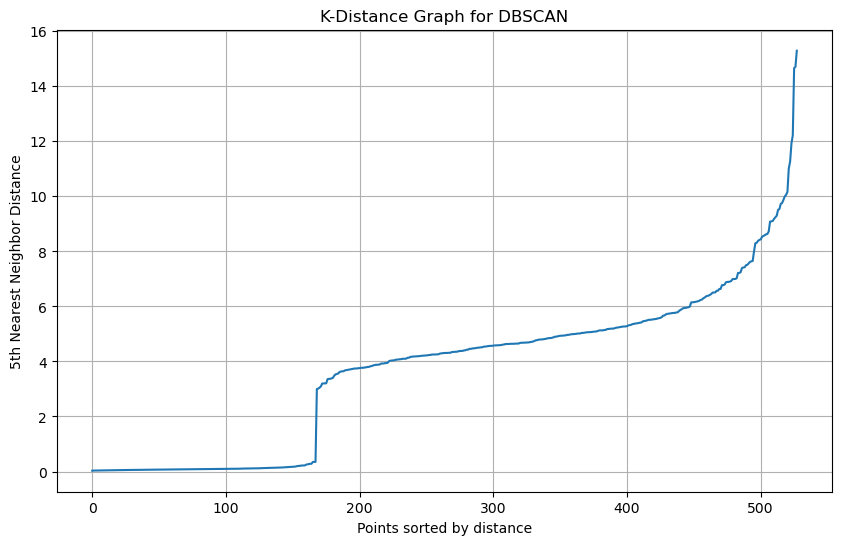

In [8]:
#determine eps using k distance graph
k = 5
nbrs = NearestNeighbors(n_neighbors=k).fit(numerical_features)
distances, _ = nbrs.kneighbors(numerical_features)
k_distances = np.sort(distances[:, k-1])

plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.title("K-Distance Graph for DBSCAN")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}th Nearest Neighbor Distance")
plt.grid(True)
plt.show()

To estimate the most suitable value for eps in DBSCAN a k-distance graph was generated using the 5th nearest neighbour distance for each point.The graph shows quite a gradual increase in distance values, then followed by an upward bend toward the end. This elbow region shows a reasonable eps value slightly before the sharp rise where points begin to be more sparsely distributed. Selecting eps in this region will allow DBSCAN to capture dense clusters and treat more isolated observations as potential noise.

In [9]:
#fit DBSCAN (choose eps based on elbow from graph)
dbscan = DBSCAN(eps=8, min_samples=40)
dbscan_labels = dbscan.fit_predict(numerical_features)

#add labels to dataset
clustered_df['DBSCAN_Cluster'] = dbscan_labels

#number of clusters and silhouette score
n_clusters_db = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
if n_clusters_db > 1:
    sil_dbscan = silhouette_score(numerical_features[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
    print(f"DBSCAN found {n_clusters_db} clusters; Silhouette Score = {sil_dbscan:.3f}")
else:
    print("DBSCAN found only 1 cluster or all noise; silhouette score not applicable")

DBSCAN found 2 clusters; Silhouette Score = 0.472


/var/folders/d9/dm2yq7r106g6jwpvs94hpq4c0000gq/T/ipykernel_5658/4237930456.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=db_clusters, x='DBSCAN_Cluster', y=feature, palette='Set2')


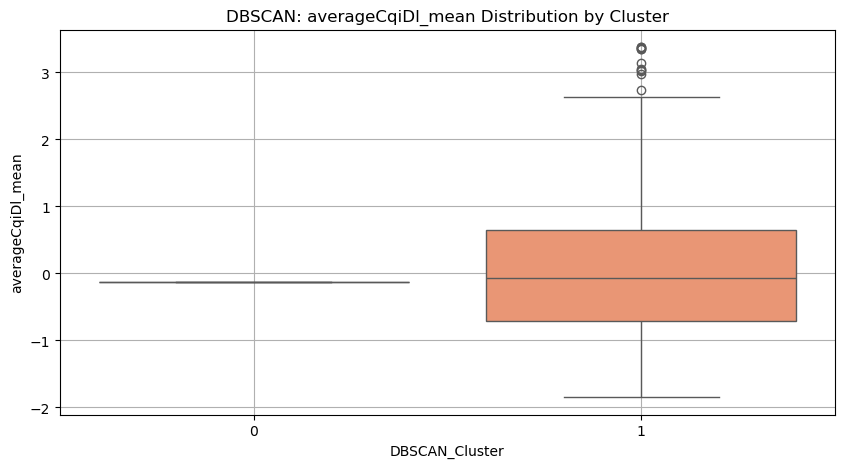

/var/folders/d9/dm2yq7r106g6jwpvs94hpq4c0000gq/T/ipykernel_5658/4237930456.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=db_clusters, x='DBSCAN_Cluster', y=feature, palette='Set2')


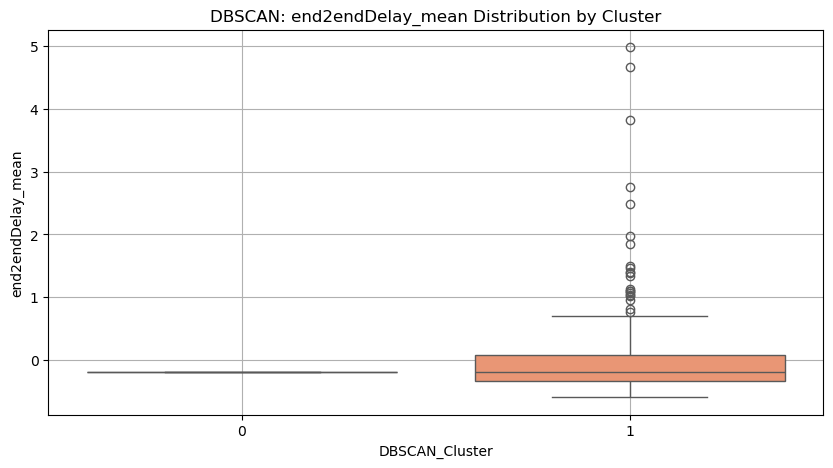

/var/folders/d9/dm2yq7r106g6jwpvs94hpq4c0000gq/T/ipykernel_5658/4237930456.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=db_clusters, x='DBSCAN_Cluster', y=feature, palette='Set2')


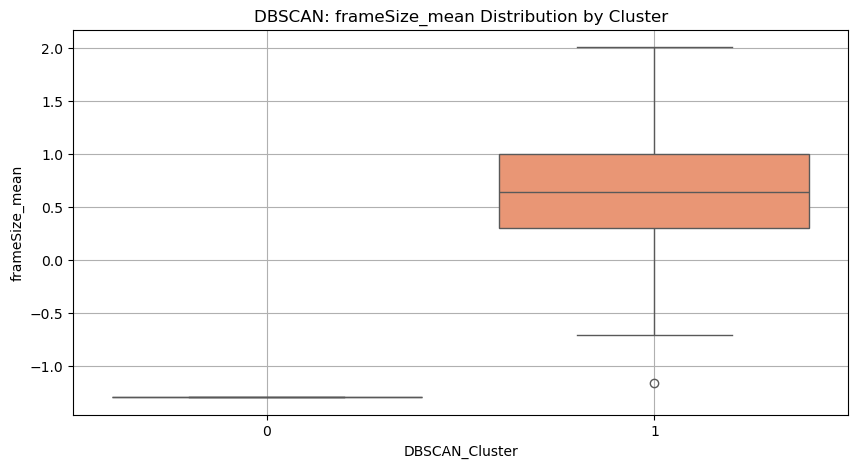

/var/folders/d9/dm2yq7r106g6jwpvs94hpq4c0000gq/T/ipykernel_5658/4237930456.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=db_clusters, x='DBSCAN_Cluster', y=feature, palette='Set2')


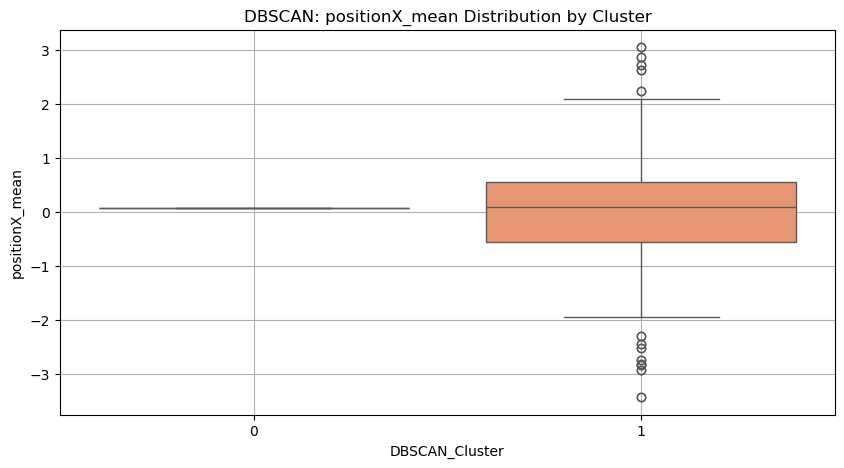

/var/folders/d9/dm2yq7r106g6jwpvs94hpq4c0000gq/T/ipykernel_5658/4237930456.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=db_clusters, x='DBSCAN_Cluster', y=feature, palette='Set2')


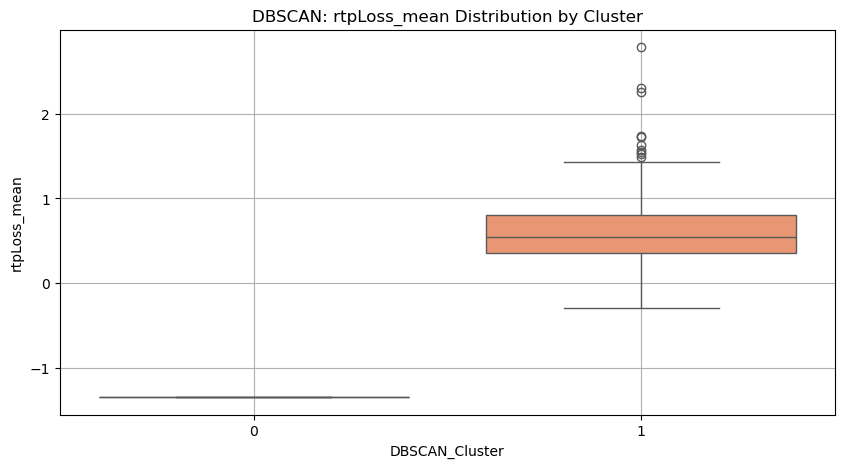

In [10]:
#exclude noise for more meaningful analysis
db_clusters = clustered_df[clustered_df['DBSCAN_Cluster'] != -1]

#boxplots for selected features
selected_features = ['averageCqiDl_mean', 'end2endDelay_mean', 'frameSize_mean', 'positionX_mean', 'rtpLoss_mean']

for feature in selected_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=db_clusters, x='DBSCAN_Cluster', y=feature, palette='Set2')
    plt.title(f"DBSCAN: {feature} Distribution by Cluster")
    plt.grid(True)
    plt.show()


## DBSCAN Visualisation ##

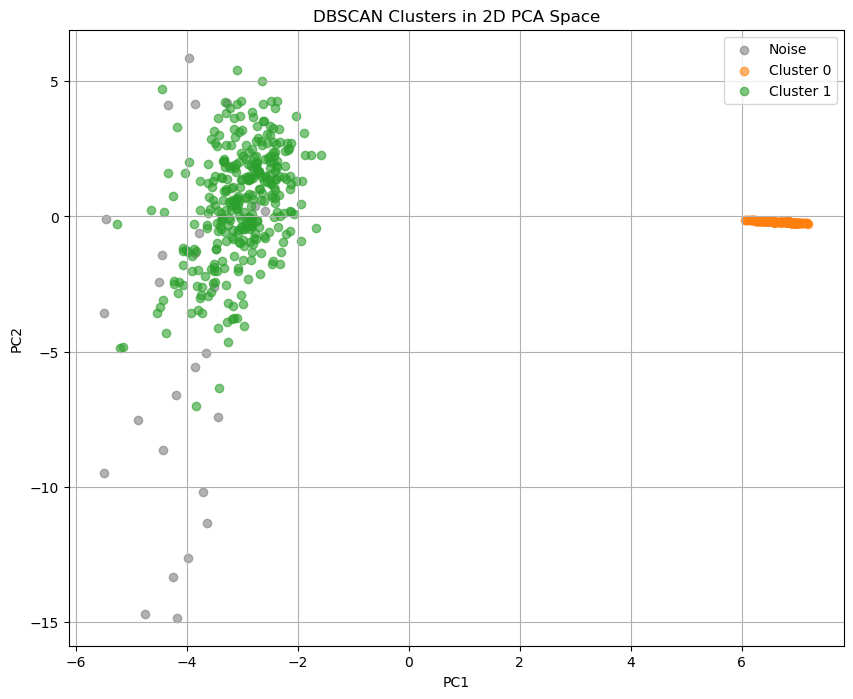

In [11]:
plt.figure(figsize=(10,8))
unique_labels = np.unique(dbscan_labels)
colors = ['grey' if label == -1 else plt.cm.tab10(i % 10) for i, label in enumerate(unique_labels)]

for i, label in enumerate(unique_labels):
    plt.scatter(
        pca_2d[dbscan_labels == label, 0],
        pca_2d[dbscan_labels == label, 1],
        c=np.array([colors[i]]),
        label=f'Cluster {label}' if label != -1 else 'Noise',
        alpha=0.6
    )
plt.title("DBSCAN Clusters in 2D PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

DBSCAN identified two clusters along with a small number of noise points, and after excluding this noise, the silhouette score of 0.472 suggests a well-defined cluster separation. DBSCAN is able to capture meaningful structure in the data without forcing all points into clusters, unlike K-Means. The PCA visualisation further confirms this separation by showing two dense regions and a small set of scattered noise points. Overall, the results show that DBSCAN successfully identifies dense performance patterns while isolating outliers. 

## Agglomerative Clustering ##

In [12]:
linkages = ['ward', 'complete', 'average', 'single']
for linkage in linkages:
    agglo = AgglomerativeClustering(n_clusters=3, linkage=linkage)
    labels = agglo.fit_predict(numerical_features)
    sil = silhouette_score(numerical_features, labels)
    print(f"{linkage} linkage → silhouette score: {sil:.3f}")

#best linkage
best_linkage = 'average'
agglo = AgglomerativeClustering(n_clusters=3, linkage=best_linkage)
agglo_labels = agglo.fit_predict(numerical_features)
clustered_df['Agglo_Cluster'] = agglo_labels

ward linkage → silhouette score: 0.347
complete linkage → silhouette score: 0.249
average linkage → silhouette score: 0.548
single linkage → silhouette score: 0.548


Agglomerative clustering was evaluated using four linkage methods: ward, complete, average, and single.
Based on the silhouette scores, average and single linkage produced the strongest clustering structure of 0.548. 
This outperformed ward and complete linkage so average linkage was selected for further analysis, as it provided the best balance between compact clusters and separation.

## PCA for 2D analysis ##

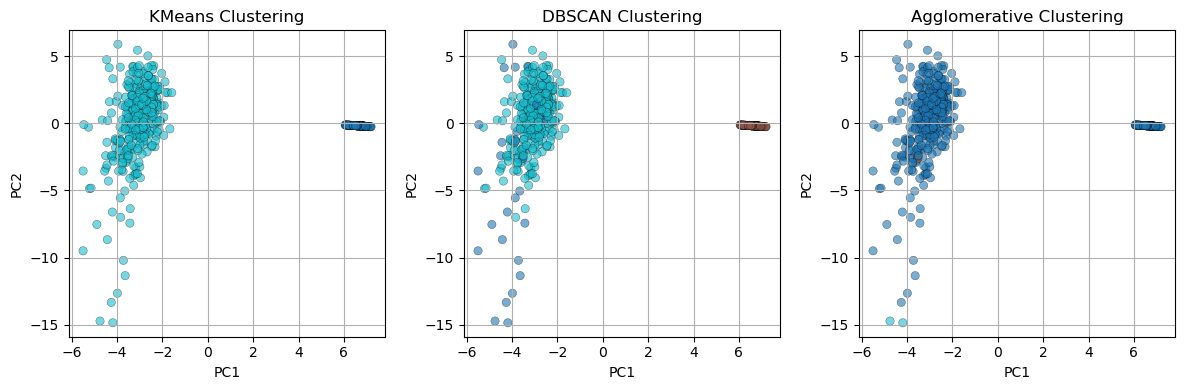

In [13]:
pca = PCA(n_components=2)
pca_2d = pca.fit_transform(numerical_features)

plt.figure(figsize=(12, 4))
for i, labels, title in zip(range(3),
                            [kmeans_labels, dbscan_labels, agglo_labels],
                            ['KMeans', 'DBSCAN', 'Agglomerative']):
    plt.subplot(1, 3, i+1)
    plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=labels, cmap='tab10', alpha=0.6, edgecolor='k', linewidth=0.3)
    plt.title(f"{title} Clustering")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
plt.tight_layout()
plt.show()


Although Agglomerative clustering achieved the highest silhouette score, the visual comparison shows that all three methods are capturing a similar underlying structure.

## Silhouette Score Comparison ##

/var/folders/d9/dm2yq7r106g6jwpvs94hpq4c0000gq/T/ipykernel_5658/3349666656.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=score_df, x="Method", y="Silhouette Score", palette='Set2')


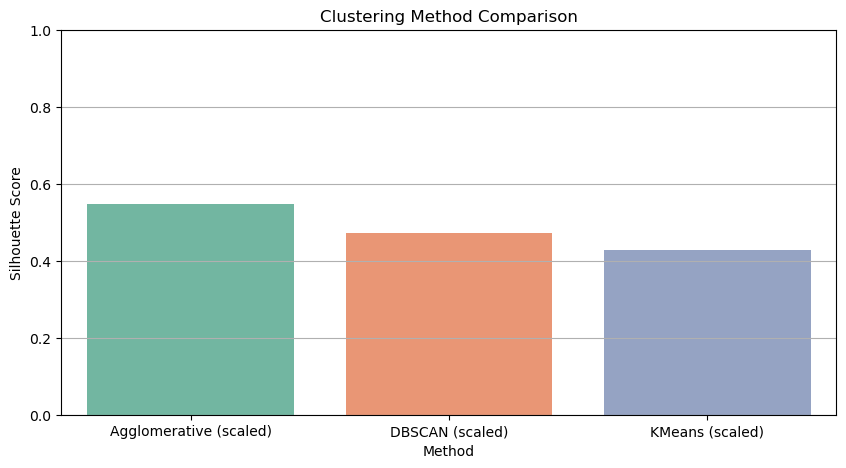

In [14]:
scores = {
    "KMeans (scaled)": silhouette_score(numerical_features, kmeans_labels),
    "DBSCAN (scaled)": sil_dbscan if n_clusters_db>1 else 0,
    "Agglomerative (scaled)": silhouette_score(numerical_features, agglo_labels)
}

score_df = pd.DataFrame(list(scores.items()), columns=["Method", "Silhouette Score"])
score_df.sort_values(by="Silhouette Score", ascending=False, inplace=True)

#plot
plt.figure(figsize=(10, 5))
sns.barplot(data=score_df, x="Method", y="Silhouette Score", palette='Set2')
plt.title("Clustering Method Comparison")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

Agglomerative clustering achieved the highest Silhouette score, followed by DBSCAN and then K-Means. This suggests that hierarchical clustering provides the most well defined cluster separation for this dataset. All methods identify meaningful structure, however, Agglomerative clustering appears to capture the underlying relationships more effectively based on this metric.

## Box Plot of Key Features per cluster ##

/var/folders/d9/dm2yq7r106g6jwpvs94hpq4c0000gq/T/ipykernel_5658/364762381.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clustered_df, x='DBSCAN_Cluster', y=feature, palette='Set2')


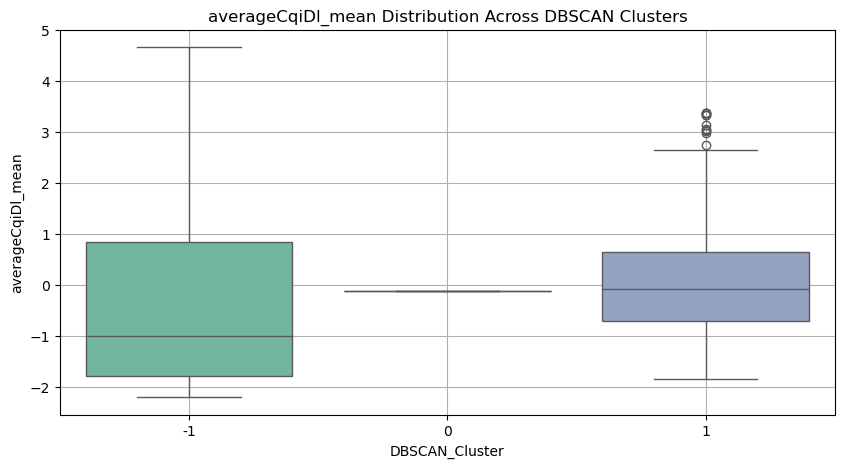

/var/folders/d9/dm2yq7r106g6jwpvs94hpq4c0000gq/T/ipykernel_5658/364762381.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clustered_df, x='DBSCAN_Cluster', y=feature, palette='Set2')


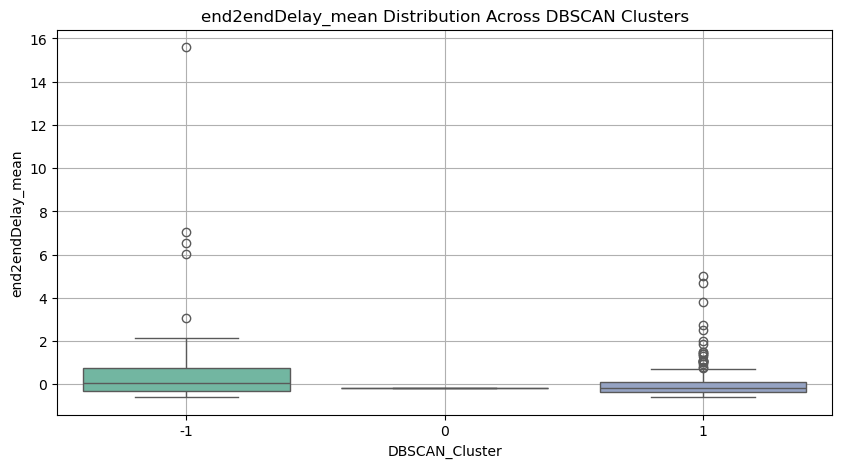

/var/folders/d9/dm2yq7r106g6jwpvs94hpq4c0000gq/T/ipykernel_5658/364762381.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clustered_df, x='DBSCAN_Cluster', y=feature, palette='Set2')


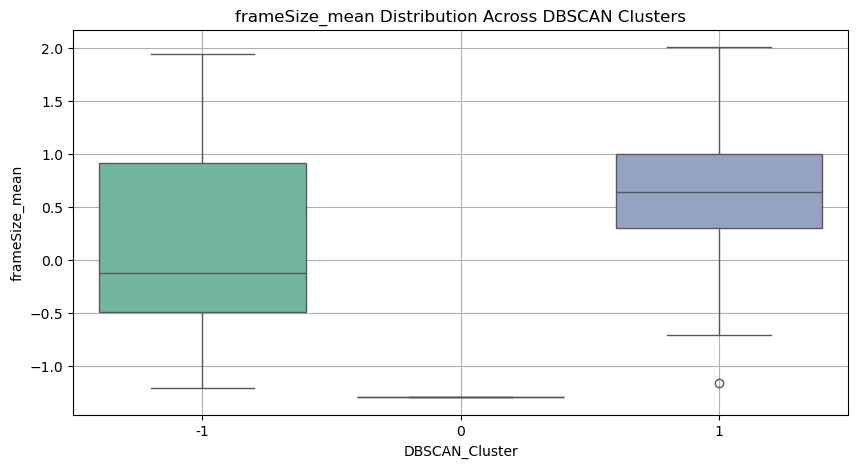

/var/folders/d9/dm2yq7r106g6jwpvs94hpq4c0000gq/T/ipykernel_5658/364762381.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clustered_df, x='DBSCAN_Cluster', y=feature, palette='Set2')


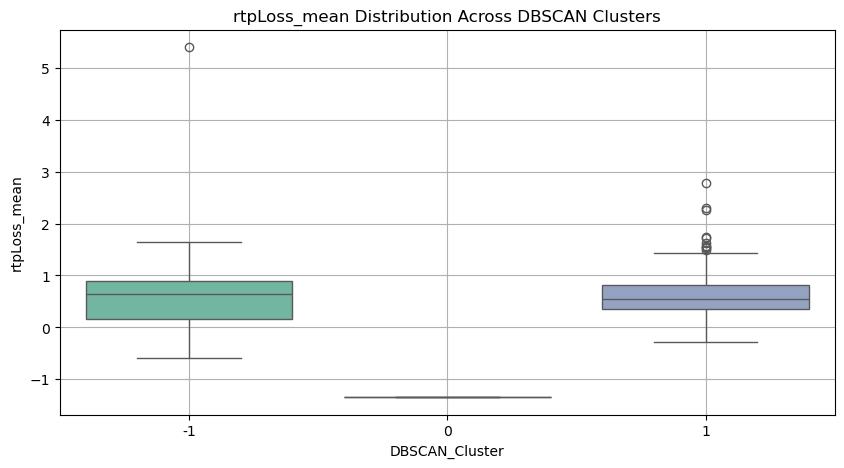

In [15]:
selected_features = ['averageCqiDl_mean','end2endDelay_mean','frameSize_mean','rtpLoss_mean']

for feature in selected_features:
    plt.figure(figsize=(10,5))
    sns.boxplot(data=clustered_df, x='DBSCAN_Cluster', y=feature, palette='Set2')
    plt.title(f"{feature} Distribution Across DBSCAN Clusters")
    plt.grid(True)
    plt.show()

The boxplots of key performance metrics show noticeable differences across clusters, particularly in average CQI, delay, frame size, and RTP loss. These variations confirm that the clusters represent distinct performance behaviours rather than randomised groupings. The separation is consistent with the PCA and silhouette score results, further supporting the clustering structure.

## Conclusion ## 

Overall, K-Means, DBSCAN, and Agglomerative clustering all demonstrate that meaningful groupings exist within the dataset. Agglomerative clustering achieved the highest silhouette scores, but based on both quantitative metrics and visual analysis, Agglomerative clustering offers the most robust segmentation for this dataset. 